In [49]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import datetime
from scipy import stats
from math import sqrt
import math,os

In [50]:
#录入path路径下所有的'.npy'结尾的文件
path = 'C:/Users/Administrator/Documents'

#获取所有path下所有文件
dirs = os.listdir(path)
data = {}
#开始录入
for x in dirs:
    #如果以.npy结尾则录入
    if os.path.splitext(x)[1]=='.npy':
        name = os.path.splitext(x)[0]
        file = path+'\\'+x
        value = np.load(file)
        data[name]=value
        
#展示录入的所有文件
data.keys()

dict_keys(['AdjFactor', 'BPS', 'BSQ0_TOT_ASSETS', 'CAPQ0_FLOAT_A', 'CAPQ0_FLOAT_A_SHR', 'ClosePrice', 'ClosePrice_index', 'dates', 'EPS_BASIC', 'EPS_dates', 'EPS_ticker_names', 'fd_dates', 'fd_tic', 'FIQ0_S_FA_BPS', 'FIQ0_S_FA_ROE', 'HighestPrice', 'index_ClosePrice', 'index_ticker_names', 'l2_dates', 'l2_ticker_names', 'LowestPrice', 'OpenPrice', 'PRC', 'S_LI_INITIATIVEBUYRATE', 'S_LI_INITIATIVESELLRATE', 'ticker_names', 'ticker_names_index', 'ticker_names_wind', 'TradeStatus', 'TradingDays', 'Turnover', 'Volume', 'VWAP', 'WIND_IDX_INDCLS2_MEMBER', 'WIND_INDCLS_MEMBER'])

In [51]:
#录入path路径下所有的'.npy'结尾的文件
path = 'C:/Users/Administrator/Documents/COP'

#获取所有path下所有文件
dirs = os.listdir(path)
cop_data = {}
#开始录入
for x in dirs:
    #如果以.npy结尾则录入
    if os.path.splitext(x)[1]=='.xlsx':
        name = os.path.splitext(x)[0]
        file = path+'\\'+x
        value = pd.read_excel(file)
        cop_data[name]=value
        
#展示录入的所有文件
cop_data.keys()

dict_keys(['account_payables', 'account_receivables', 'deferred_revenue_current', 'deferred_revenue_noncurrent', 'inventory', 'operating_income', 'other_expense', 'prepaid', 'R_D_expense'])

In [52]:
#原始数据处理
for i in cop_data.keys():
    cop_data[i]['证券代码'] = cop_data[i]['证券代码'].apply(lambda x: x[:6])
    cop_data[i].index = cop_data[i]['证券代码'].values
    cop_data[i].drop(['证券简称','证券代码'],axis=1,inplace=True)
    cop_data[i].columns = list(range(2000,2021))
    cop_data[i] = cop_data[i].T

In [53]:
#处理得到净值变化
for i in  ['account_payables', 'account_receivables', 'deferred_revenue_current', 'deferred_revenue_noncurrent', 'inventory',
           'other_expense', 'prepaid',]:
    cop_data[i].iloc[:,:] = np.diff(cop_data[i],1,axis=0,prepend=np.nan)
    cop_data[i].fillna(0,inplace=True)
cop_data['R_D_expense'].fillna(0,inplace=True)

In [54]:
#读取其他数据
tic = data['ticker_names']
dates = pd.to_datetime(data['dates'])
fd_dates = pd.to_datetime(data['fd_dates'])
fd_tick = data['fd_tic']

#统一tic universe
tics = (set(fd_tick)&set(cop_data['operating_income'].columns)&set(tic))

#读取和fama因子模型相关的市值，BP，ROE，资产回报率
ClosePrice = pd.DataFrame(data['ClosePrice'],index = tic,columns=dates).T[tics]
MarketCap = pd.DataFrame(data['CAPQ0_FLOAT_A'],index = tic,columns=dates).T[tics]
BPS = pd.DataFrame(data['FIQ0_S_FA_BPS'].T,index = fd_dates,columns=fd_tick)[tics]
TotalAsset = pd.DataFrame(data['BSQ0_TOT_ASSETS'].T,index = fd_dates,columns=fd_tick)[tics]
ROE = pd.DataFrame(data['FIQ0_S_FA_ROE'].T,index = fd_dates,columns=fd_tick)[tics]


In [55]:
#对fama5因子相关数据进行数据处理，获得SMB HML RMW CMA的原始对应数据
TotalAsset = TotalAsset.resample('Q').last()
ROE = ROE.resample('Q').last()
BPS = BPS.resample('Q').last()
MC = MarketCap.resample('Q').last()
TotalAsset = TotalAsset.resample('Q').last()

def june_data(df):
    for i in df.index:
        if i.month != 6:
            df.drop(i,axis=0,inplace=True)
    return(df)

TotalAsset = june_data(TotalAsset)
ROE = june_data(ROE)
BPS = june_data(BPS)
MC = june_data(MC)
AR = np.log(TotalAsset)-np.log(TotalAsset.shift(1))
AR[abs(AR)==np.inf]=np.nan

<ipython-input-55-3cad21c5198c>:18: RuntimeWarning: divide by zero encountered in log
  AR = np.log(TotalAsset)-np.log(TotalAsset.shift(1))


In [56]:
#获取COP因子值：
non_scaled = (cop_data['operating_income']+cop_data['R_D_expense']-cop_data['account_receivables']-cop_data['inventory']-cop_data['prepaid']+cop_data['deferred_revenue_current']+cop_data['deferred_revenue_noncurrent']+cop_data['account_payables']+cop_data['other_expense'])[tics]
non_scaled.index = TotalAsset.index[9:-1]

#除以年末总资产
COP = non_scaled / TotalAsset.loc[non_scaled.index,tics]
COP[abs(COP)==np.inf] = np.nan

COP.tail()

,002884,300250,300069,300206,300479,600439,000812,600377,300155,002048,...,000032,601816,002612,600636,300234,600638,300223,002324,300049,603969
2016-06-30,0.272331,0.022770,-0.061102,-0.031220,-0.116826,0.090701,0.153882,0.125119,-0.020384,0.121525,...,0.018068,0.049867,-0.027922,0.036957,0.033366,0.023240,-0.046729,-0.069735,0.138399,-0.051131
2017-06-30,0.233208,0.034386,0.152521,0.025277,-0.062383,0.040645,0.071120,0.124917,-0.014121,0.054814,...,0.090398,0.070658,0.022590,0.720227,-0.025663,0.249092,-0.009380,-0.002313,0.060837,-0.129805
2018-06-30,0.194410,-0.272012,-0.065086,0.129033,0.051860,-0.041856,0.053542,0.106419,0.023610,0.110294,...,0.153468,0.070057,0.020934,-0.456714,-0.019620,-0.092909,0.109376,0.124153,0.056222,0.095404
2019-06-30,0.281988,0.179023,0.064749,0.210836,0.031296,0.032556,-0.018003,0.113020,0.122878,0.114268,...,0.020991,0.087729,0.030931,0.093207,0.008916,-0.122015,0.090822,0.087441,0.110348,0.037180
2020-06-30,0.181817,-0.133028,-0.086128,0.485674,0.106657,0.042219,0.019370,0.066138,0.086849,0.160104,...,0.204818,0.023078,0.087275,0.122939,0.090075,-0.071090,-0.702076,0.152279,0.095004,0.081126


In [57]:
#对数据进行中心化和标准化处理，去除极端值，这不改变每期的大小排序
def normalization(data,ax=1):
    def centrilization(x):
        y=abs(x-x.median()).median()*5
        x[x>(x.median()+y)]=x.median()+y
        x[x<(x.median()-y)]=x.median()-y
        return(x)
    data=data.apply(centrilization,axis=ax)
    data=data.apply(lambda x: (x-x.mean())/x.std(),axis=ax)
    return(data)

COP = normalization(COP,ax=0)
COP.tail()

,002884,300250,300069,300206,300479,600439,000812,600377,300155,002048,...,000032,601816,002612,600636,300234,600638,300223,002324,300049,603969
2016-06-30,0.881987,0.326204,-0.717193,-0.947621,-1.511850,1.440914,1.926669,0.821264,-0.590845,0.528576,...,-0.519428,-0.420728,-2.002316,-0.183407,0.230449,0.138108,-0.736588,-1.419239,1.389121,-0.790305
2017-06-30,0.010177,0.437463,1.447866,-0.523196,-0.806467,0.687893,0.632459,0.815239,-0.503299,-0.175757,...,0.558881,0.419485,-0.571995,2.063706,-0.448866,1.928253,-0.297589,-0.487109,-0.373697,-1.571030
2018-06-30,-0.854368,-1.634366,-0.796769,0.256262,0.673702,-0.553210,0.357591,0.262059,0.024099,0.409999,...,1.499120,0.395202,-0.618872,-2.372511,-0.379328,-0.782512,1.098237,1.261326,-0.478580,0.663843
2019-06-30,1.097196,1.822820,1.447866,0.870793,0.407273,0.566209,-0.761212,0.459463,1.411651,0.451955,...,-0.475847,1.109396,-0.335793,0.250194,-0.050921,-1.013212,0.880151,0.753771,0.751575,0.086050
2020-06-30,-1.134993,-1.166064,-1.217073,2.211700,1.383674,0.711581,-0.176785,-0.942538,0.908048,0.935890,...,2.264652,-1.503355,1.259672,0.479389,0.883069,-0.609570,-1.938476,1.479401,0.402842,0.522155


mean                    2.3637e-18
median                 -0.00805475
max                        3.32154
min                       -3.41024
std                       0.957102
skewness    [0.025678435128306226]
kurtosis     [-0.0355079910519569]
dtype: object


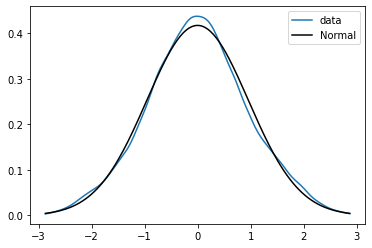

In [58]:
#COP因子的描述性统计量(对观察期内全部样本数据)，图为COP的PDF
def statistics(close):
    
    mc = np.mean(close)
    stdc = np.std(close)
    print(pd.Series({'mean':mc,'median':np.median(close),'max':np.max(close),'min':np.min(close),'std':stdc,'skewness':stats.skew(close.T),'kurtosis':stats.kurtosis(close.T)}))
    
    #distribution plot
    x = np.linspace(mc-3*stdc,mc+3*stdc,200)
    y = stats.norm.pdf(x,mc,stdc)
    kde = stats.gaussian_kde(close)
    plt.plot(x,kde(x),label='data')
    plt.plot(x,y,color='black',label='Normal')
    plt.legend()
    plt.show()
    
statistics(np.hstack([COP.loc[k,:].dropna().values.reshape(1,-1) for k in COP.index]))

In [59]:
#对price取log return
ClosePrice = ClosePrice.resample('Q').last()
ClosePrice = june_data(ClosePrice)
Re = np.log(ClosePrice.shift(-1)) - np.log(ClosePrice)
Re.tail()

,002884,300250,300069,300206,300479,600439,000812,600377,300155,002048,...,000032,601816,002612,600636,300234,600638,300223,002324,300049,603969
2017-06-30,NaN,-0.350881,-1.006869,-0.306870,-0.325415,-0.421282,-0.421060,-0.032913,-0.497715,-0.525798,...,-0.734129,NaN,-0.163725,0.066971,-0.727345,-0.183927,0.116915,-0.435130,-0.234021,-0.777323
2018-06-30,-0.128775,0.146156,0.278849,0.085129,-0.029637,-0.167768,0.136230,0.215997,0.078935,-0.117954,...,0.288275,NaN,-0.100713,-0.268312,0.672713,-0.243596,0.200074,0.158642,-0.385662,0.100898
2019-06-30,0.267338,-0.071931,0.086166,1.007936,0.032822,-0.058922,-0.400759,-0.047576,0.161675,0.369146,...,0.788350,NaN,0.057137,0.114435,-0.167559,-0.298013,1.288771,0.861362,0.114200,-0.046233
2020-06-30,0.606506,-0.348878,-0.286133,-0.047722,-0.364124,-0.138444,0.315085,0.038051,0.037678,0.179146,...,0.039221,-0.049927,1.349526,-0.100974,0.426615,-0.076633,-0.397522,0.158614,-0.262265,0.020479
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#获取上证指数年度return
market_index = pd.DataFrame(data['index_ClosePrice'],index=data['index_ticker_names'],columns=pd.to_datetime(data['EPS_dates'])).T['000001']
market_index = market_index.resample('Q').last()
market_index = june_data(market_index)
market_index_return = np.log(market_index.shift(-1))-np.log(market_index)
market_index_return.tail()

2017-06-30   -0.114369
2018-06-30    0.045134
2019-06-30    0.001944
2020-06-30    0.142320
2021-06-30         NaN
Name: 000001, dtype: float64

In [61]:
#获取SMB HML RMW CMA各组收益
smb = []
hml = []
rmw = []
cma = []

ob_d = COP.index

def fama_groups(df,g=3):
    label = list(range(g))
    fama_sort = pd.qcut(df.dropna(),g,labels=label)

    big = fama_sort[fama_sort==label[-1]].index
    small = fama_sort[fama_sort==label[0]].index
    return(big,small)

for i in ob_d:
    h,l = fama_groups(MC.loc[i,:])
    b,s = fama_groups(BPS.loc[i,:])
    w,r = fama_groups(ROE.loc[i,:])
    c,a = fama_groups(TotalAsset.loc[i,:],2)
    
    hml.append(Re.loc[i,h].mean()-Re.loc[i,l].mean())
    smb.append(Re.loc[i,s].mean()-Re.loc[i,b].mean())
    rmw.append(Re.loc[i,r].mean()-Re.loc[i,w].mean())
    cma.append(Re.loc[i,c].mean()-Re.loc[i,a].mean())
    
hml = pd.Series(hml,index=ob_d)
smb = pd.Series(smb,index=ob_d)
rmw = pd.Series(rmw,index=ob_d)
cma = pd.Series(cma,index=ob_d)

In [62]:
#去除金融行业的数据 #882115 882116 882117
#获取wind行业分类
ind = pd.DataFrame(data['WIND_IDX_INDCLS2_MEMBER'],index=tic,columns=dates).T[tics]
ind= ind.resample('y').last()
ind.tail()

,002884,300250,300069,300206,300479,600439,000812,600377,300155,002048,...,000032,601816,002612,600636,300234,600638,300223,002324,300049,603969
2017-12-31,882102,882120,882102,882113,882120,882112,882103,882104,882120,882105,...,882120,0,882106,882101,882102,882118,882121,882101,882114,882101
2018-12-31,882102,882120,882102,882113,882120,882112,882103,882104,882120,882105,...,882120,0,882106,882101,882102,882118,882121,882101,882114,882101
2019-12-31,882102,882120,882102,882113,882120,882112,882103,882104,882120,882105,...,882120,0,882106,882101,882102,882118,882121,882101,882114,882101
2020-12-31,882102,882120,882102,882113,882120,882112,882103,882104,882120,882105,...,882120,882104,882106,882107,882102,882118,882121,882101,882114,882101
2021-12-31,882102,882120,882102,882113,882120,882112,882103,882104,882120,882105,...,882120,882104,882106,882107,882102,882118,882121,882101,882114,882101


In [63]:
#去除所有行业曾为882115 882116 882117的数据
dropindex = []
for i in ind.columns:
    if (882115 == ind.loc[:,i]).sum()>0 or (882116 == ind.loc[:,i]).sum()>0 or (882117 == ind.loc[:,i]).sum()>0 :
        dropindex.append(i)
drop_finance = set(tics)-set(dropindex)

In [64]:
#创建分析类 实行每期对COP值排序分组并计算各组收益，其中h-l为多空组，因子值最高组-最低组
class factor_analysis(object):
    def __init__(self, factors):
        self.factors = factors
    
    #等值加权
    def E_weight(self,ob_t,tt='cvd'):
        ew_re = pd.DataFrame(None,index=ob_t,columns=list(range(1,11)))
        for i in self.factors.index:
            selected = self.Re.loc[i,:].dropna().index
            groups = pd.qcut(self.factors.loc[i,selected],10,labels=list(range(1,11)))
            ew_re.loc[i,:] = self.Re.loc[i,groups.index].groupby(by=groups).mean()

        #多空组合
        ew_re['h-l'] = ew_re[10]-ew_re[1]
        
        #cumulative return
        ew_re_cum = ew_re.cumsum()

        #plot
        plt.figure(figsize=(16,20))
        plt.subplot(211)
        for i in range(1,11):
            plt.plot(ew_re[i],label='group'+str(i))
        plt.plot(ew_re['h-l'],label='group h-l')
        plt.title('equal_weighted_log_return_'+tt)
        plt.legend()

        plt.subplot(212)
        for i in range(1,11):
            plt.plot(ew_re_cum[i],label='group'+str(i))
        plt.plot(ew_re_cum['h-l'],label='group h-l')
        plt.title('equal_weighted_cumulative_log_return_'+tt)
        plt.legend()
        
        m = np.exp(ew_re_cum.iloc[-1,:].mean())
        
        def evaluate(df1,rf=0.0384,n=20):
            df1 = df1.astype('float')
            
            #CAPM
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            capm_alpha = beta[0][0,0]
            capm_beta = beta[1][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_capm = beta.T/se
            
            #fama 3-factor
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama3_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama3 = beta.T/se
            
            #fama 5-factor
            
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t],rmw[ob_t],cma[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama5_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama5 = beta.T/se
            
            df = df1.cumsum()
            df = np.exp(df.astype('float'))
            Maxdrawdown = -round(((df-df.expanding().max())/df.expanding().max()).min(),3)
            alpha = (df[-1]-m)/n
            sr = round((df[-1]-1-rf*n)/(df.std()*12**0.5),3)
            return(pd.Series({'TotalReturn':round(df1.cumsum()[-1],4),'AnnualReturn':round(df1.cumsum()[-1]/20,4),'Sharpe':sr,
                              'CAPM Alpha':[round(capm_alpha,4),round(t_value_capm[0,0],4)],'Beta':[round(capm_beta,4),round(t_value_capm[0,1],4)]
                              ,'fama-3-factor alpha':[round(fama3_alpha,4),round(t_value_fama3[0,0],4)]
                              ,'fama-5-factor alpha':[round(fama5_alpha,4),round(t_value_fama5[0,0],4)],'Maxdrawdown':Maxdrawdown}))
        return(ew_re.apply(evaluate,axis=0).T)
    
    #市值加权
    def MC_weight(self,ob_t,tt='cvd'):
        mw_re = pd.DataFrame(None,index=ob_t,columns=list(range(1,11)))

        #收益率乘以市值再分组加总后，除以各组市值加总即为各组市值加权平均收益，这一方法在迭代上具有优势
        mw = self.Re*self.MarketCap

        for i in self.factors.index:
            selected = self.Re.loc[i,:].dropna().index
            groups = pd.qcut(self.factors.loc[i,selected],10,labels=list(range(1,11)))
            mw_re.loc[i,:] = mw.loc[i,groups.index].groupby(by=groups).sum()/self.MarketCap.loc[i,groups.index].groupby(by=groups).sum()

        #多空组合
        mw_re['h-l'] = mw_re[10]-mw_re[1]
        
        #cumulative return
        mw_re_cum = mw_re.cumsum()

        #plot
        plt.figure(figsize=(16,20))
        plt.subplot(211)
        for i in range(1,11):
            plt.plot(mw_re[i],label='group'+str(i))
        plt.plot(mw_re['h-l'],label='group h-l')
        plt.title('MarketCap_weighted_log_return_'+tt)
        plt.legend()

        plt.subplot(212)
        for i in range(1,11):
            plt.plot(mw_re_cum[i],label='group'+str(i))
        plt.plot(mw_re_cum['h-l'],label='group h-l')
        plt.title('MarketCap_weighted_cumulative_log_return_'+tt)
        plt.legend()
        
        m = np.exp(mw_re_cum.iloc[-1,:].mean())
        def evaluate(df1,rf=0.0384,n=20):
            df1 = df1.astype('float')
            
            #CAPM
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            capm_alpha = beta[0][0,0]
            capm_beta = beta[1][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_capm = beta.T/se
            
            #fama 3-factor
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama3_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama3 = beta.T/se
            
            #fama 5-factor
            
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t],rmw[ob_t],cma[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama5_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama5 = beta.T/se
            
            df = df1.cumsum()
            df = np.exp(df.astype('float'))
            Maxdrawdown = -round(((df-df.expanding().max())/df.expanding().max()).min(),3)
            alpha = (df[-1]-m)/n
            sr = round((df[-1]-1-rf*n)/(df.std()*12**0.5),3)
            return(pd.Series({'TotalReturn':round(df1.cumsum()[-1],4),'AnnualReturn':round(df1.cumsum()[-1]/20,4),'Sharpe':sr,
                              'CAPM Alpha':[round(capm_alpha,4),round(t_value_capm[0,0],4)],'Beta':[round(capm_beta,4),round(t_value_capm[0,1],4)]
                              ,'fama-3-factor alpha':[round(fama3_alpha,4),round(t_value_fama3[0,0],4)]
                              ,'fama-5-factor alpha':[round(fama5_alpha,4),round(t_value_fama5[0,0],4)],'Maxdrawdown':Maxdrawdown}))

        return(mw_re.apply(evaluate,axis=0).T)


,TotalReturn,AnnualReturn,Sharpe,CAPM Alpha,Beta,fama-3-factor alpha,fama-5-factor alpha,Maxdrawdown
1,0.1841,0.0092,-0.226,"[-0.0214, -0.631]","[1.0921, 10.0026]","[-0.0893, -3.4662]","[-0.0516, -1.5798]",0.719
2,0.3178,0.0159,-0.183,"[-0.0133, -0.4185]","[1.0301, 10.0647]","[-0.084, -3.4353]","[-0.0408, -1.3803]",0.715
3,0.6244,0.0312,0.035,"[0.0012, 0.0388]","[1.0346, 10.4293]","[-0.0596, -2.4127]","[-0.0092, -0.3309]",0.684
4,0.4673,0.0234,-0.08,"[-0.0069, -0.2127]","[1.0581, 10.0622]","[-0.0719, -2.7687]","[-0.0222, -0.742]",0.75
5,0.5915,0.0296,0.015,"[-0.0009, -0.0267]","[1.052, 10.2386]","[-0.0598, -2.459]","[-0.015, -0.5204]",0.716
6,0.6877,0.0344,0.077,"[0.0044, 0.1423]","[1.0292, 10.4177]","[-0.0518, -1.9533]","[0.006, 0.2067]",0.694
7,0.9383,0.0469,0.229,"[0.0159, 0.5208]","[1.042, 10.559]","[-0.042, -1.8353]","[0.0043, 0.1658]",0.715
8,1.1031,0.0552,0.311,"[0.024, 0.7928]","[1.0335, 10.5763]","[-0.0351, -1.3923]","[0.0097, 0.3192]",0.667
9,1.0247,0.0512,0.292,"[0.0205, 0.7269]","[1.0253, 11.2649]","[-0.0437, -2.1028]","[0.0032, 0.1432]",0.673
10,1.2565,0.0628,0.407,"[0.0326, 1.2076]","[0.9878, 11.3506]","[-0.0247, -0.9429]","[0.0224, 0.7449]",0.604


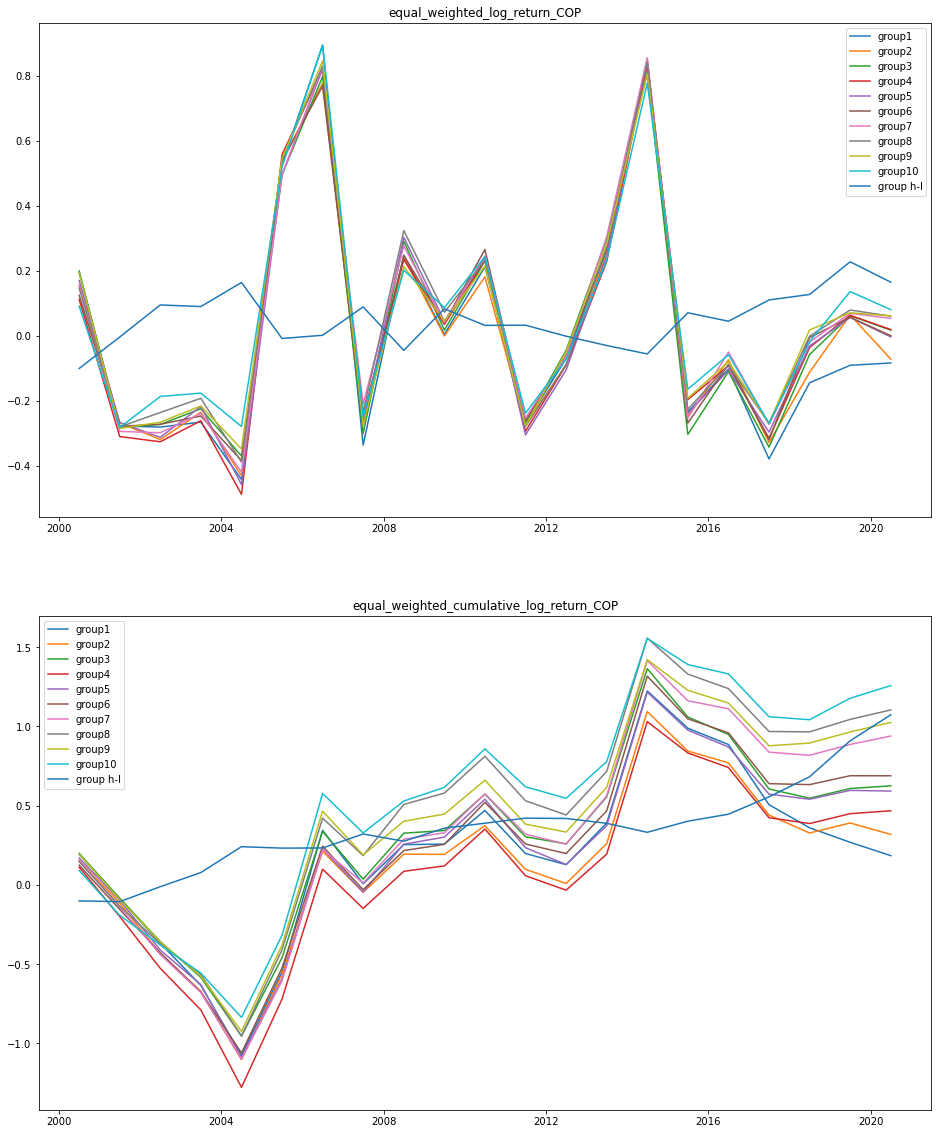

In [65]:
#传入参数
cvd_ana = factor_analysis(COP[drop_finance])
cvd_ana.Re = Re[drop_finance]
cvd_ana.MarketCap = MC[drop_finance]

#等值加权
cvd_ana.E_weight(ob_t = COP.index,tt='COP')

,TotalReturn,AnnualReturn,Sharpe,CAPM Alpha,Beta,fama-3-factor alpha,fama-5-factor alpha,Maxdrawdown
1,-0.6637,-0.0332,-1.212,"[-0.0636, -2.582]","[1.16, 14.6015]","[-0.0948, -3.2536]","[-0.0711, -1.7958]",0.724
2,-0.337,-0.0168,-1.114,"[-0.0463, -3.3057]","[1.0963, 24.2767]","[-0.0659, -4.1119]","[-0.0633, -2.852]",0.668
3,0.0625,0.0031,-0.583,"[-0.0276, -1.794]","[1.1074, 22.342]","[-0.0387, -1.931]","[-0.0169, -0.6349]",0.644
4,-0.2366,-0.0118,-1.176,"[-0.0401, -1.7182]","[1.0445, 13.8832]","[-0.0666, -2.2184]","[-0.0238, -0.6467]",0.722
5,0.1591,0.008,-0.55,"[-0.0215, -1.1966]","[1.0557, 18.1816]","[-0.0381, -1.7943]","[-0.0186, -0.6892]",0.658
6,0.2713,0.0136,-0.398,"[-0.0163, -1.0487]","[1.0594, 21.1304]","[-0.0247, -1.1619]","[0.0071, 0.2684]",0.629
7,0.7175,0.0359,0.16,"[0.0059, 0.2751]","[1.0237, 14.7304]","[-0.0049, -0.1732]","[0.045, 1.3067]",0.679
8,0.3685,0.0184,-0.251,"[-0.0112, -0.6583]","[1.0433, 18.961]","[-0.0246, -1.1162]","[0.0063, 0.2298]",0.609
9,0.4649,0.0232,-0.128,"[-0.0062, -0.4041]","[1.0276, 20.7359]","[-0.032, -1.9052]","[-0.009, -0.4175]",0.638
10,0.5721,0.0286,0.003,"[0.0, 0.0017]","[0.9862, 13.4205]","[-0.0282, -0.9531]","[0.0139, 0.413]",0.6


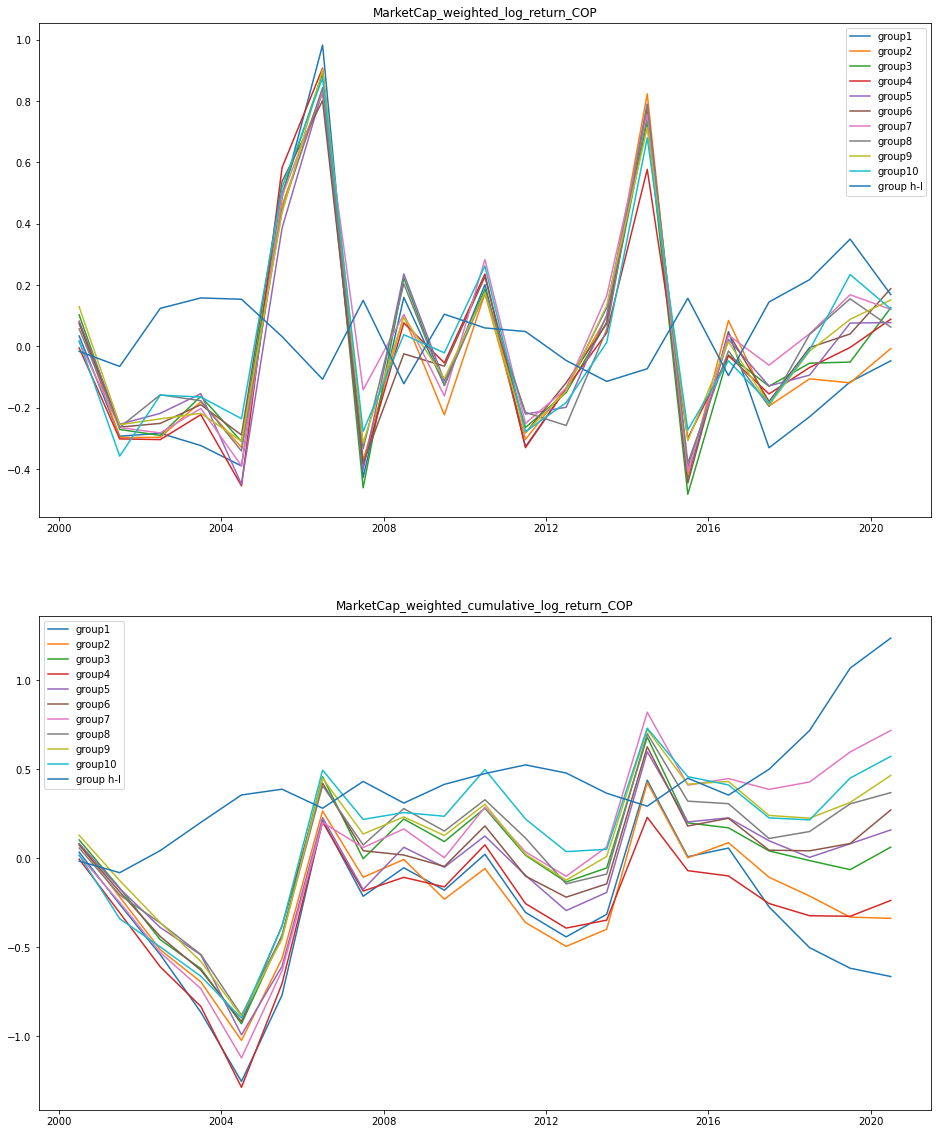

In [66]:
#市值加权
cvd_ana.MC_weight(ob_t = COP.index,tt='COP')

In [67]:
#我们选取wind行业标码为 882106(耐用消费品与服装) 882114(制药，生命科技与生物科学) 882109（零售业) 行业
#获取行业内股票代码
ind_882106 = ind.iloc[-1,:][ind.iloc[-1,:]==882106].index & tics
ind_882114 = ind.iloc[-1,:][ind.iloc[-1,:]==882114].index & tics
ind_882109 = ind.iloc[-1,:][ind.iloc[-1,:]==882109].index & tics

In [68]:
#传入数据
ind_882106_test = factor_analysis(COP.loc[:,ind_882106])
ind_882106_test.Re = Re.loc[:,ind_882106]
ind_882106_test.MarketCap = MC

ind_882114_test = factor_analysis(COP.loc[:,ind_882114])
ind_882114_test.Re = Re.loc[:,ind_882114]
ind_882114_test.MarketCap = MC

ind_882109_test = factor_analysis(COP.loc[:,ind_882109])
ind_882109_test.Re = Re.loc[:,ind_882109]
ind_882109_test.MarketCap = MC

,TotalReturn,AnnualReturn,Sharpe,CAPM Alpha,Beta,fama-3-factor alpha,fama-5-factor alpha,Maxdrawdown
1,-0.2689,-0.0134,-0.446,"[-0.0377, -0.8267]","[0.9026, 6.1364]","[-0.1357, -3.0201]","[-0.0939, -1.5571]",0.729
2,0.158,0.0079,-0.333,"[-0.0196, -0.5599]","[0.9827, 8.7116]","[-0.0699, -2.2547]","[-0.0444, -1.1037]",0.653
3,-0.1883,-0.0094,-0.665,"[-0.0421, -1.086]","[1.2029, 9.6108]","[-0.1077, -3.2732]","[-0.0742, -1.9097]",0.805
4,0.884,0.0442,0.171,"[0.0113, 0.2674]","[1.1158, 8.1761]","[-0.0702, -1.9297]","[-0.0469, -0.9635]",0.768
5,0.3463,0.0173,-0.113,"[-0.0138, -0.319]","[1.0972, 7.879]","[-0.0896, -2.6199]","[-0.0506, -1.2365]",0.749
6,0.5949,0.0297,0.016,"[0.0008, 0.0192]","[0.9967, 7.0995]","[-0.099, -2.1302]","[-0.0423, -0.6995]",0.561
7,0.7934,0.0397,0.127,"[0.009, 0.2105]","[1.0441, 7.5901]","[-0.0584, -1.7037]","[-0.0419, -0.8921]",0.757
8,0.4979,0.0249,-0.056,"[-0.0023, -0.0544]","[0.944, 6.8314]","[-0.0993, -2.685]","[-0.0584, -1.2393]",0.728
9,1.4741,0.0737,0.466,"[0.045, 0.8325]","[0.9147, 5.2517]","[-0.0309, -0.5867]","[0.0041, 0.0565]",0.8
10,0.8421,0.0421,0.182,"[0.008, 0.1865]","[1.1637, 8.4071]","[-0.061, -1.522]","[-0.0732, -1.3256]",0.741


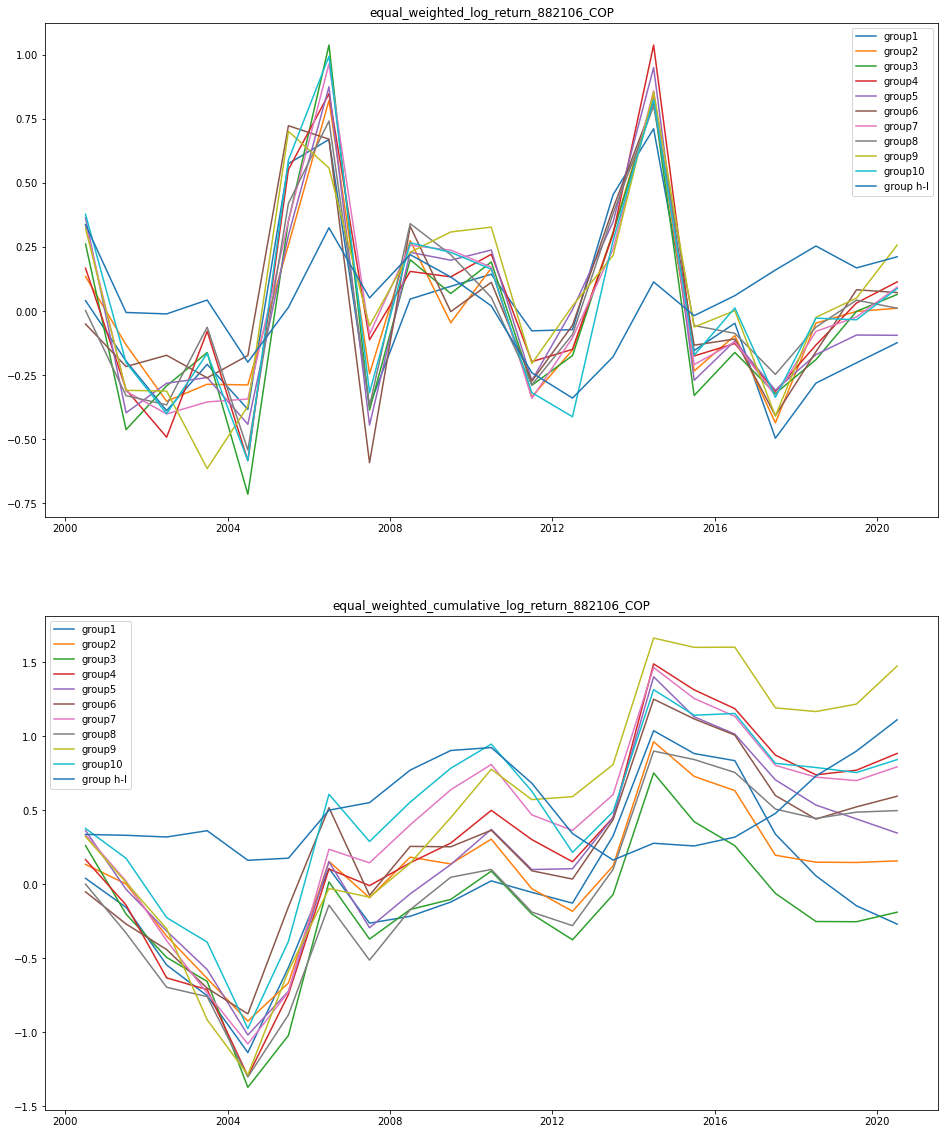

In [69]:
#882106 等值加权
ind_882106_test.E_weight(ob_t = COP.index,tt='882106_COP')

,TotalReturn,AnnualReturn,Sharpe,CAPM Alpha,Beta,fama-3-factor alpha,fama-5-factor alpha,Maxdrawdown
1,-0.3221,-0.0161,-0.49,"[-0.0386, -0.8143]","[0.8443, 5.5188]","[-0.1014, -1.7021]","[-0.1171, -1.4999]",0.754
2,0.661,0.0331,0.076,"[0.0059, 0.1501]","[0.9265, 7.2859]","[-0.0003, -0.0069]","[0.0476, 0.7247]",0.59
3,-0.6582,-0.0329,-1.215,"[-0.0708, -1.3424]","[1.4315, 8.4123]","[-0.1053, -1.4788]","[-0.0651, -0.7396]",0.797
4,0.9653,0.0483,0.221,"[0.012, 0.3448]","[1.2318, 10.9836]","[-0.0311, -0.7343]","[-0.03, -0.5065]",0.673
5,-0.8141,-0.0407,-1.649,"[-0.0707, -1.5782]","[1.1591, 8.0181]","[-0.1141, -1.9635]","[-0.0231, -0.4029]",0.759
6,0.8608,0.043,0.191,"[0.0148, 0.3091]","[0.9478, 6.1193]","[-0.0486, -0.7974]","[-0.0123, -0.1485]",0.483
7,0.7227,0.0361,0.142,"[0.0047, 0.1288]","[1.0766, 9.1118]","[-0.0357, -0.7823]","[-0.0579, -0.9273]",0.781
8,0.6075,0.0304,0.03,"[0.0075, 0.1707]","[0.7776, 5.5061]","[-0.0767, -1.7305]","[-0.0588, -0.9793]",0.671
9,0.8183,0.0409,0.226,"[0.0115, 0.2306]","[0.9952, 6.1794]","[-0.0406, -0.6975]","[0.0414, 0.5561]",0.814
10,0.3214,0.0161,-0.269,"[-0.0155, -0.3135]","[1.1156, 7.009]","[-0.0519, -0.9387]","[-0.0823, -1.1342]",0.747


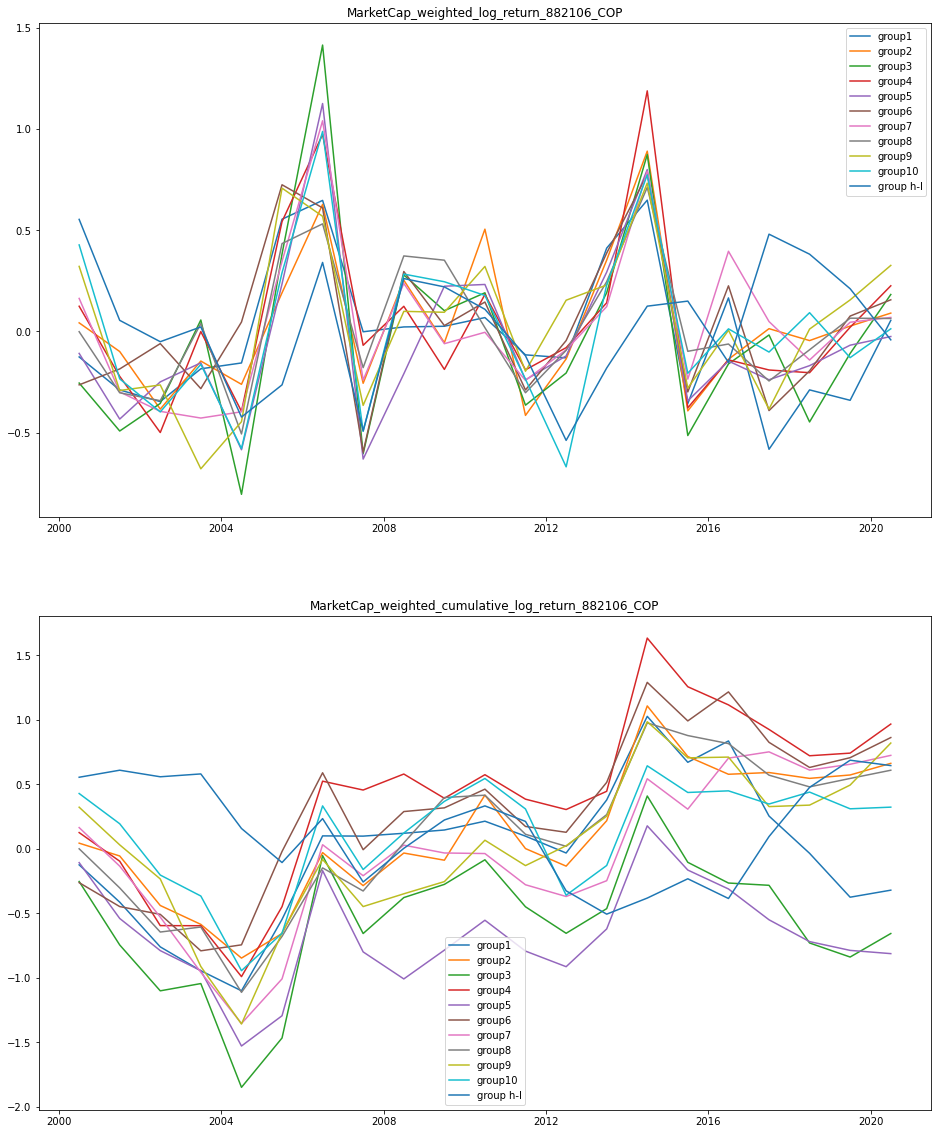

In [70]:
#882106 市值加权
ind_882106_test.MC_weight(ob_t = COP.index,tt='882106_COP')

,TotalReturn,AnnualReturn,Sharpe,CAPM Alpha,Beta,fama-3-factor alpha,fama-5-factor alpha,Maxdrawdown
1,0.7378,0.0369,0.066,"[0.0076, 0.1615]","[0.9984, 6.5845]","[-0.0506, -1.1455]","[-0.0187, -0.3169]",0.713
2,0.9382,0.0469,0.289,"[0.0216, 0.4635]","[0.8353, 5.549]","[-0.0532, -0.9867]","[0.0605, 1.0144]",0.736
3,0.9027,0.0451,0.204,"[0.0175, 0.4013]","[0.925, 6.5897]","[-0.0742, -1.6709]","[0.0326, 0.7836]",0.732
4,1.1363,0.0568,0.378,"[0.0304, 0.7749]","[0.8582, 6.7745]","[-0.0422, -0.9464]","[0.0391, 0.7756]",0.706
5,1.5025,0.0751,0.414,"[0.0466, 1.1098]","[0.9048, 6.6831]","[-0.039, -0.83]","[0.0448, 0.7937]",0.69
6,1.8956,0.0948,0.523,"[0.0645, 1.5071]","[0.9343, 6.7699]","[-0.0219, -0.5068]","[0.0689, 1.5123]",0.721
7,0.9482,0.0474,0.239,"[0.022, 0.4772]","[0.8399, 5.6528]","[-0.0562, -1.0963]","[0.0403, 0.6965]",0.755
8,1.4138,0.0707,0.418,"[0.0446, 1.2547]","[0.825, 7.2016]","[-0.0332, -1.0672]","[-0.0113, -0.2806]",0.637
9,1.1276,0.0564,0.277,"[0.0319, 0.8796]","[0.7898, 6.7498]","[-0.0326, -0.7642]","[0.0692, 1.6141]",0.572
10,1.9694,0.0985,0.632,"[0.064, 1.3367]","[1.0787, 6.9831]","[-0.0187, -0.3249]","[0.0817, 1.3175]",0.669


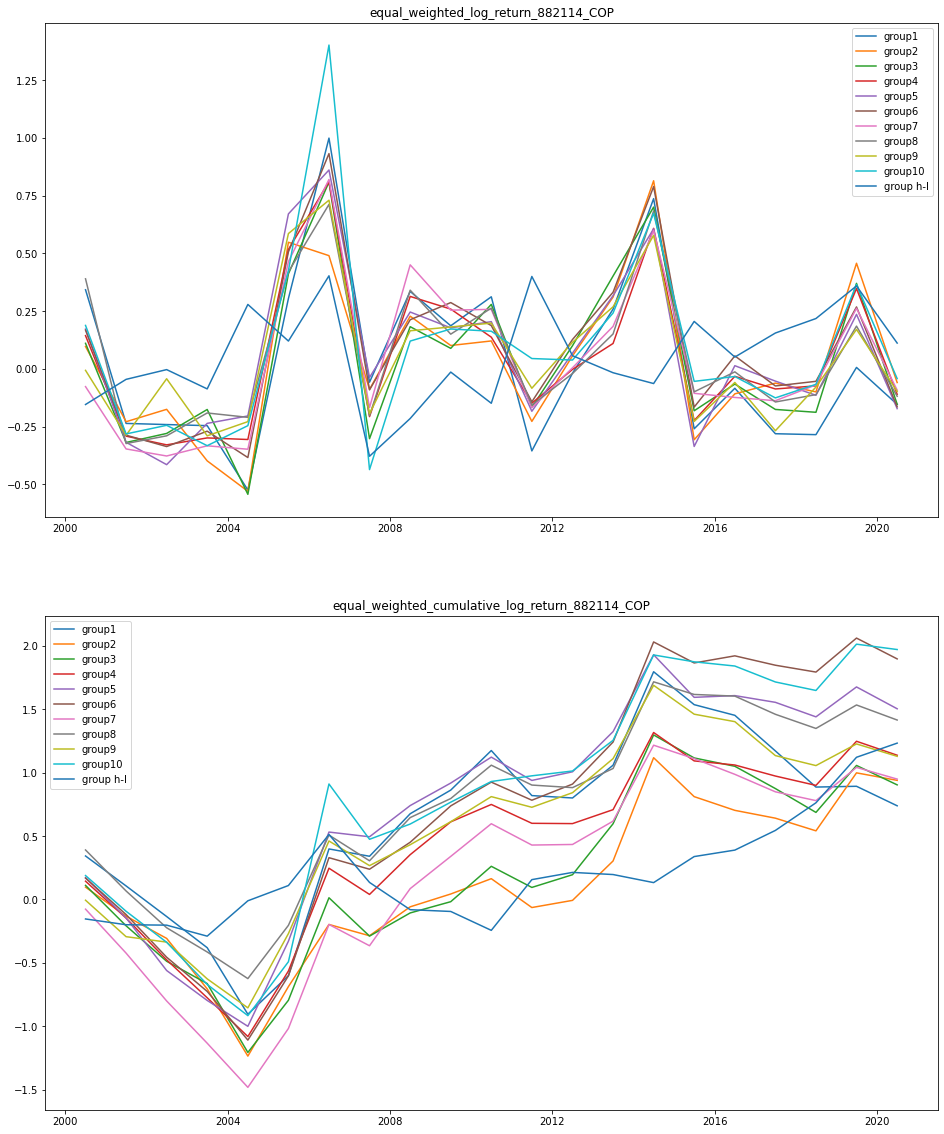

In [71]:
#882114 等值加权
ind_882114_test.E_weight(ob_t = COP.index,tt='882114_COP')

,TotalReturn,AnnualReturn,Sharpe,CAPM Alpha,Beta,fama-3-factor alpha,fama-5-factor alpha,Maxdrawdown
1,-0.8701,-0.0435,-0.617,"[-0.0672, -1.116]","[0.935, 4.813]","[-0.1227, -1.604]","[-0.1512, -1.5244]",0.833
2,0.6516,0.0326,0.091,"[0.0083, 0.1644]","[0.8242, 5.0655]","[-0.0638, -1.0072]","[0.068, 0.9567]",0.747
3,0.8975,0.0449,0.208,"[0.0192, 0.4013]","[0.852, 5.5112]","[-0.0552, -0.9548]","[0.0464, 0.89]",0.73
4,1.1863,0.0593,0.446,"[0.0327, 0.8618]","[0.8627, 7.0509]","[-0.0215, -0.4488]","[0.0454, 0.7798]",0.712
5,1.1455,0.0573,0.363,"[0.0301, 0.6756]","[0.8863, 6.168]","[-0.0376, -0.6714]","[0.0104, 0.1373]",0.68
6,1.5824,0.0791,0.511,"[0.0549, 1.1991]","[0.7423, 5.0292]","[-0.0062, -0.1056]","[0.106, 1.5954]",0.683
7,0.8623,0.0431,0.215,"[0.0173, 0.3117]","[0.8601, 4.7942]","[-0.0168, -0.2228]","[0.0935, 1.014]",0.745
8,1.7497,0.0875,0.575,"[0.0618, 1.5764]","[0.7784, 6.1517]","[-0.014, -0.3132]","[0.0272, 0.4996]",0.545
9,1.0363,0.0518,0.271,"[0.0286, 0.6376]","[0.7528, 5.2069]","[0.0125, 0.2023]","[0.1101, 1.5582]",0.511
10,1.8027,0.0901,0.796,"[0.0557, 1.1463]","[1.0922, 6.9671]","[-0.0084, -0.1348]","[0.0809, 1.0903]",0.66


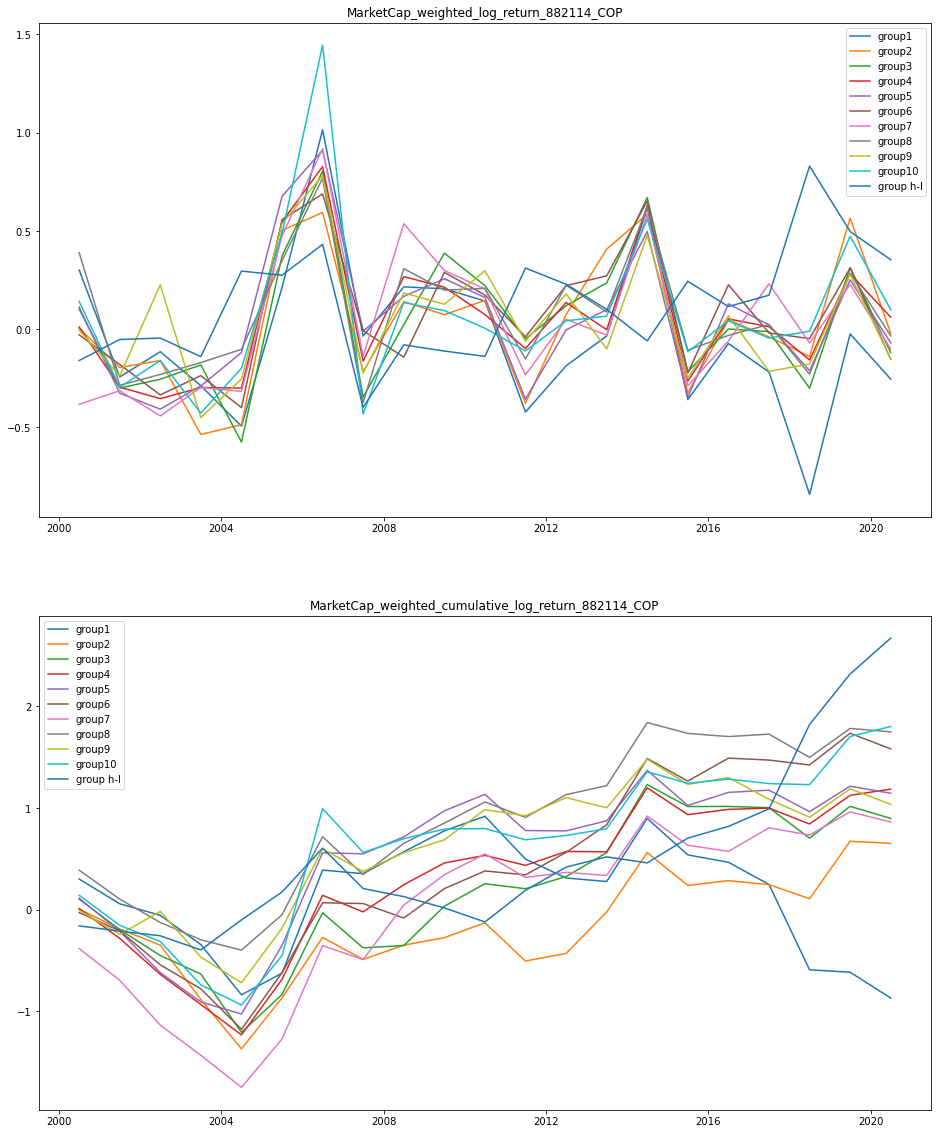

In [72]:
#882114 市值加权
ind_882114_test.MC_weight(ob_t = COP.index,tt='882114_COP')

,TotalReturn,AnnualReturn,Sharpe,CAPM Alpha,Beta,fama-3-factor alpha,fama-5-factor alpha,Maxdrawdown
1,-0.324,-0.0162,-0.462,"[-0.046, -0.9089]","[1.1097, 6.7929]","[-0.1568, -2.9299]","[-0.1109, -1.5411]",0.763
2,1.226,0.0613,0.304,"[0.0266, 0.6784]","[1.1535, 9.1358]","[-0.0649, -1.566]","[-0.0001, -0.0013]",0.666
3,0.1891,0.0095,-0.271,"[-0.0221, -0.5376]","[1.1263, 8.5084]","[-0.1002, -2.2992]","[-0.0594, -1.0544]",0.745
4,0.8956,0.0448,0.16,"[0.0098, 0.2428]","[1.1922, 9.1961]","[-0.0641, -1.4012]","[-0.0183, -0.2984]",0.63
5,-0.2204,-0.011,-0.888,"[-0.0347, -0.8899]","[0.8764, 6.9742]","[-0.0852, -1.8563]","[-0.0567, -0.9209]",0.677
6,-0.3006,-0.015,-1.091,"[-0.0402, -1.1239]","[0.9378, 8.1333]","[-0.0909, -2.1318]","[-0.0492, -0.9404]",0.737
7,-0.2144,-0.0107,-0.487,"[-0.0349, -0.8869]","[0.8967, 7.0564]","[-0.0697, -1.5632]","[-0.0468, -0.7893]",0.723
8,-0.1492,-0.0075,-0.504,"[-0.0357, -0.8824]","[1.0371, 7.9453]","[-0.1148, -2.7558]","[-0.121, -2.0842]",0.709
9,0.6926,0.0346,0.065,"[0.0075, 0.1446]","[0.9252, 5.5579]","[-0.0789, -1.3437]","[-0.1055, -1.326]",0.673
10,0.633,0.0317,0.029,"[-0.001, -0.0226]","[1.1295, 7.8108]","[-0.0704, -1.2935]","[-0.0773, -1.025]",0.646


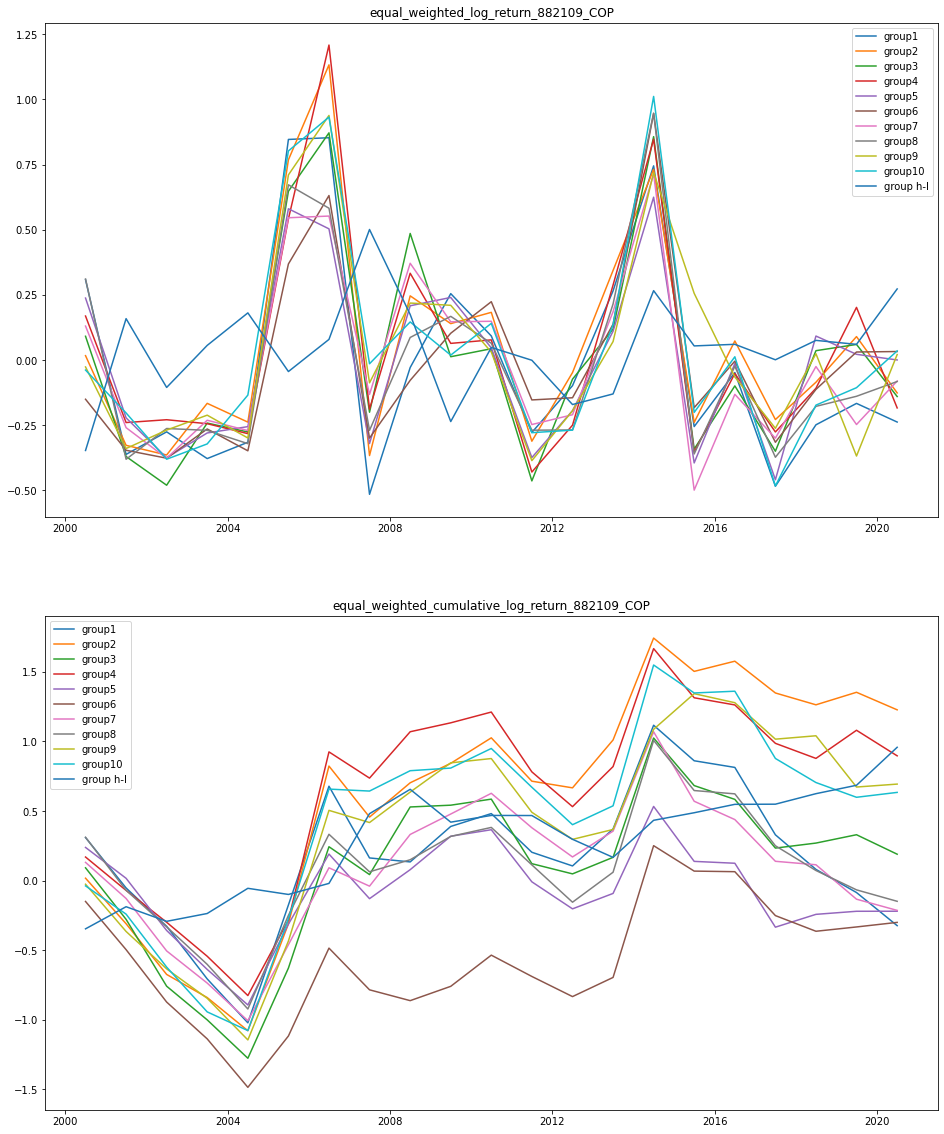

In [73]:
#882109 等值加权
ind_882109_test.E_weight(ob_t = COP.index,tt='882109_COP')

,TotalReturn,AnnualReturn,Sharpe,CAPM Alpha,Beta,fama-3-factor alpha,fama-5-factor alpha,Maxdrawdown
1,-0.2807,-0.014,-0.391,"[-0.0481, -0.8863]","[1.2592, 7.1946]","[-0.1482, -2.3141]","[-0.0846, -1.0125]",0.775
2,0.8006,0.04,0.138,"[0.0042, 0.1063]","[1.2294, 9.6232]","[-0.0658, -1.4089]","[0.0118, 0.2046]",0.657
3,0.5226,0.0261,-0.033,"[-0.0055, -0.127]","[1.1007, 7.9128]","[-0.092, -1.8766]","[-0.0436, -0.6784]",0.724
4,-0.0257,-0.0013,-0.642,"[-0.0305, -0.7281]","[1.0619, 7.8557]","[-0.1131, -2.3131]","[-0.0571, -0.8937]",0.658
5,-0.9637,-0.0482,-1.487,"[-0.0708, -1.6218]","[0.9049, 6.4229]","[-0.1134, -2.0115]","[-0.0934, -1.2016]",0.723
6,-1.2266,-0.0613,-2.677,"[-0.0836, -2.4074]","[0.9145, 8.1618]","[-0.0999, -2.1856]","[-0.0894, -1.5201]",0.73
7,-0.3646,-0.0182,-0.493,"[-0.0428, -1.0367]","[0.9223, 6.9263]","[-0.0821, -1.5681]","[-0.0791, -1.1212]",0.767
8,-0.7701,-0.0385,-0.725,"[-0.0658, -1.15]","[1.0549, 5.7193]","[-0.1856, -2.8849]","[-0.1657, -1.852]",0.823
9,0.1701,0.0085,-0.206,"[-0.0232, -0.5757]","[1.1361, 8.7271]","[-0.069, -1.3073]","[-0.0657, -0.9152]",0.62
10,0.8337,0.0417,0.118,"[0.005, 0.1114]","[1.2586, 8.7242]","[-0.0868, -1.692]","[-0.0827, -1.1605]",0.634


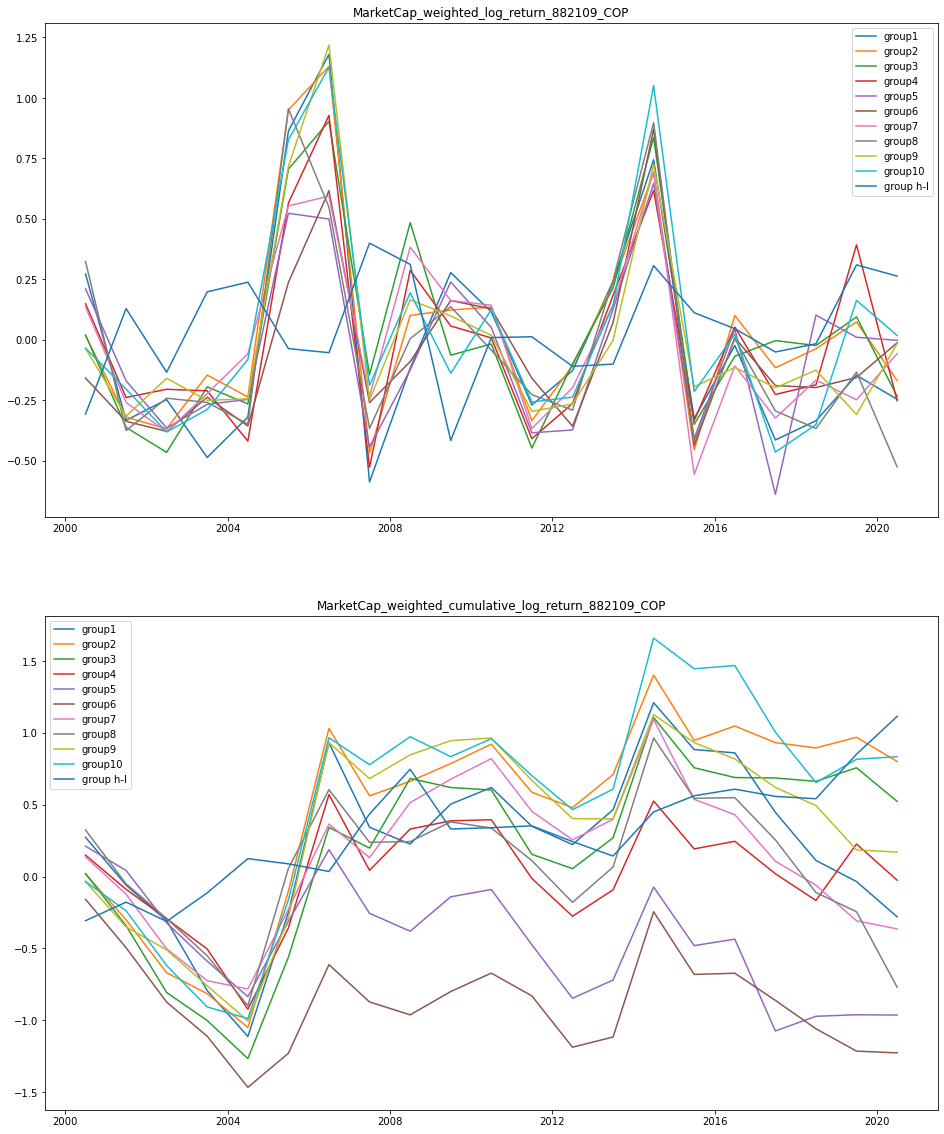

In [74]:
#882109 市值加权
ind_882109_test.MC_weight(ob_t = COP.index,tt='882109_COP')

mean         1.982531
mean(abs)    2.516290
std          2.607580
|t|>2        0.500000
dtype: float64


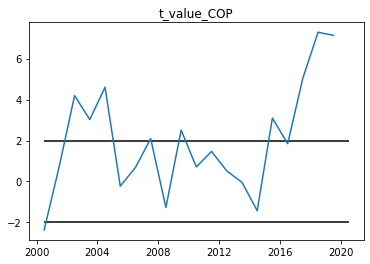

In [76]:
#回归分析 以每个截面为一个线性模型回归，探寻beta系数的t值是否具有稳定性
t_value = []
ob_t = COP.index
for i in ob_t:
    y = Re.loc[i,:].dropna()
    x = COP.loc[i,y.index]
    X = np.mat(np.stack([np.ones(shape=x.shape),x]).T)
    y = np.mat(y).T
    beta = (X.T*X).I*X.T*y
    u = y-X*beta

    #estimated variation of regression
    varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
    se = np.sqrt(np.diag(varbeta))

    #record estimation
    t_value.append((beta.T/se)[0,1])
t_value = pd.Series(t_value,index = ob_t)
plt.plot(t_value)
plt.title('t_value_COP')
plt.hlines(2,ob_t[0],ob_t[-1],colors='black')
plt.hlines(-2,ob_t[0],ob_t[-1],colors='black')
print(pd.Series({'mean':np. mean(t_value),'mean(abs)':np.mean(abs(t_value)),'std':np.std(t_value),'|t|>2':t_value[abs(t_value)>2].count()/t_value.count()}))        